This notebook demonstrates by an example that performing regression via Shapley Values is way more robust than via one simple linear regression.

For the two approaches (Linear regression and Shapley Values regression):
* A regression is performed on non-noisy data.
* Random normal noise is added to the data and then the regressor is refitted.
* Relative differences between non-noisy and noisy coefficients are computed and the result displayed as a bar plot.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from icecream import ic

# Importing regressors
from sklearn.linear_model import LinearRegression
# Adding parent dir to PYTHONPATH (temporary fix)
sys.path.insert(0, "..")  # adding parent directory to PYTHONPATH.
from svreg.svreg import SvRegression

# Fixing numpy random seed (used by sklearn) for reproducibility:
np.random.seed(seed=4242)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# I) Preprocessing the data

In [2]:
#name_dataset = "group_m_secret.csv"
name_dataset = "mtcars.csv"
num_features_retained = 10

path_dataset = os.path.join("../data", name_dataset)
if name_dataset == "group_m_secret.csv":
    index_col = "date"
    target = "qlead_auto"
else:
    index_col = "model"
    target = "mpg"

data_sv = pd.read_csv(path_dataset,
                      index_col=index_col,
                      parse_dates=True,
                      infer_datetime_format=True)
data_sv = data_sv.iloc[:, :(num_features_retained + 1)]  # +1 to retain the target feature as well.

if name_dataset == "group_m_secret.csv":
    data_sv.columns = data_sv.columns.str.strip().str.replace(" ", "_")
    data_sv.columns = data_sv.columns.str.lower()

# Counting the number of missing values per column.
print(data_sv.isna().sum())

mpg     0
cyl     0
disp    0
hp      0
drat    0
wt      0
qsec    0
vs      0
am      0
gear    0
carb    0
dtype: int64


In [3]:
# Dropping missings rows
data_sv = data_sv.dropna()

In [4]:
# Splitting dataset in features and target.
x_features = data_sv.drop(labels=target, axis=1)
y_target = data_sv[target]

nb_rows, nb_features = x_features.shape
print(f"{nb_rows} rows in the dataset.")
print(f"{nb_features} features in the dataset.")

32 rows in the dataset.
10 features in the dataset.


# II) Correlations study.

<AxesSubplot: >

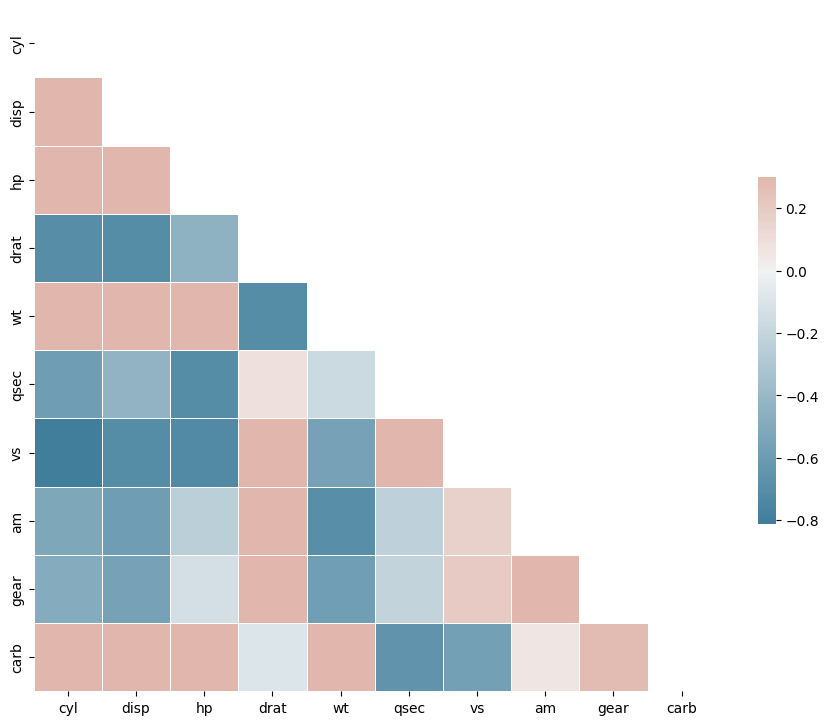

In [5]:
# Compute the correlation matrix
corr = x_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# III) Regressions.
## a. Linear regression.

In [6]:
reg = LinearRegression().fit(x_features, y_target.to_numpy().reshape(-1, 1))
coeff_without_noise = reg.coef_.ravel()
coeff_without_noise.shape

(10,)

In [7]:
# Adding random gaussian noise to the predictors:
x_features_noise = x_features.copy()

n_rows = x_features_noise.shape[0]

for feature in x_features_noise:
    std_feature = x_features_noise[feature].std()
    noise = np.random.normal(0, (1/20) * std_feature, n_rows)
    x_features_noise[feature] = x_features_noise[feature] + noise


In [8]:
reg_noise = LinearRegression().fit(x_features_noise, y_target.to_numpy().reshape(-1, 1))
coeff_with_noise = reg_noise.coef_.ravel()

In [9]:
coeff_diff_lr = coeff_with_noise - coeff_without_noise
mean_coeff = 0.5 * (np.absolute(coeff_with_noise) + np.absolute(coeff_without_noise))
relative_diff_lr = 100 * (np.absolute(coeff_diff_lr) / mean_coeff)
relative_diff_lr = np.around(relative_diff_lr, decimals=2)
relative_diff_lr

array([ 75.67,  23.32,  27.76,  56.26,   2.26,  31.34, 103.86,  12.7 ,
         9.02,  57.72])

In [10]:
sign_coeff_without_noise = np.sign(coeff_without_noise)
sign_coeff_with_noise = np.sign(coeff_with_noise)

val_sign_lr = sign_coeff_with_noise == sign_coeff_without_noise
val_sign_lr

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## b. Shapley values regression.
### 1. Without random noise.

In [11]:
sv_reg = SvRegression(
    data=data_sv,
    regressors_selected=None,
    target=target
)

# Fitting the regression.
coeffs = sv_reg.fit()

# Coefficients without noise:
coeffs_sv_without_noise = sv_reg.coeffs

0 rows have been deleted due to missing values.
32 rows in the dataset.
10 features (regressors) present in the dataset.
10 features have been selected.
Computing the 1024 linears regressions.
Linear regressions |████████████████████████████████████████⚠︎ (!) 1023/1024 [100%] in 0.7s (1450.79/s) 


### 2. With random normal noise.

In [12]:
# Adding random gaussian noise to the predictors:
data_sv_noise = data_sv.copy()
n_rows = data_sv_noise.shape[0]

for feature in data_sv.columns[1:]:
    std_feature = data_sv[feature].std()
    noise = np.random.normal(0, (1/20) * std_feature, n_rows)
    data_sv_noise[feature] = data_sv_noise[feature] + noise


In [13]:
sv_reg = SvRegression(
    data=data_sv_noise,
    regressors_selected=None,
    target=target,
)

# Fitting the regression.
coeffs = sv_reg.fit()

# Coefficients without noise:
coeffs_sv_with_noise = sv_reg.coeffs

0 rows have been deleted due to missing values.
32 rows in the dataset.
10 features (regressors) present in the dataset.
10 features have been selected.
Computing the 1024 linears regressions.
Linear regressions |████████████████████████████████████████⚠︎ (!) 1023/1024 [100%] in 0.7s (1517.95/s) 


In [14]:
coeffs_sv_without_noise = np.array([feat[1] for feat in coeffs_sv_without_noise][1:])  # we drop the intercept.
coeffs_sv_with_noise = np.array([feat[1] for feat in coeffs_sv_with_noise][1:])  # we drop the intercept.
# Relative diffs (%)
coeff_diff_sv = coeffs_sv_with_noise - coeffs_sv_without_noise
mean_coeff = 0.5 * (np.absolute(coeffs_sv_with_noise) + np.absolute(coeffs_sv_without_noise))
relative_diff_sv = 100 * (np.absolute(coeff_diff_sv) / mean_coeff)
relative_diff_sv = np.around(relative_diff_sv, decimals=2)
relative_diff_sv

array([0.58, 0.59, 1.22, 0.18, 1.6 , 0.7 , 0.2 , 0.25, 1.43, 1.83])

In [15]:
# Signs (Shapley Values regression)
sign_coeff_without_noise = np.sign(coeffs_sv_without_noise)
sign_coeff_with_noise = np.sign(coeffs_sv_with_noise)

val_sign_sv = sign_coeff_with_noise == sign_coeff_without_noise
val_sign_sv

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Text(0, 0.5, 'Relative differences (%)')

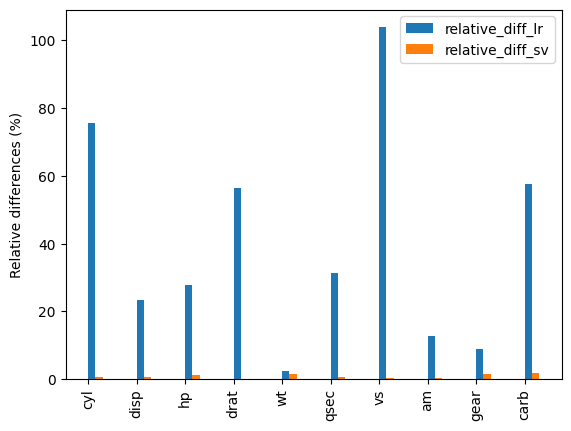

In [16]:
names = data_sv.columns[1:]
x = np.arange(0, len(names))
width = 0.15
n = 2

fig = plt.figure()
ax = fig.add_subplot(111)

# relative_diff_lr
position = x + (width*(1 - n)/2) + 1 * width
plt.bar(position, relative_diff_lr, width=width, label='relative_diff_lr')

# relative_diff_sv
position = x + (width*(1 - n)/2) + 2 * width
plt.bar(position, relative_diff_sv, width=width, label='relative_diff_sv')

plt.xticks(x, names)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Relative differences (%)")
